# Rasters and Shapes

![alt text](../resources/assets/sl_air.png "Title")

### Exercise

Data Scource - [Topography](https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/bedrock/grid_registered/georeferenced_tiff/)

Data Scource - [River Basins](https://www.fao.org/fishery/static/geonetwork/d47ba28e-31be-470d-81cf-ad3d5594fafd/data/)


- Download the data and place in the resources folder
- Use rasterio to open and plot the topography dataset
- Use Geopandas to open and plot the river basins dataset

In [1]:
import rasterio
img = rasterio.open('../resources/ETOPO1_Bed_g_geotiff.tif')
image = img.read()

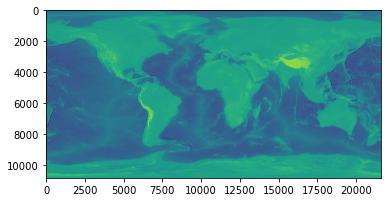

In [2]:
import matplotlib.pyplot as plt

plt.imshow(image[0])
plt.show()

<AxesSubplot:>

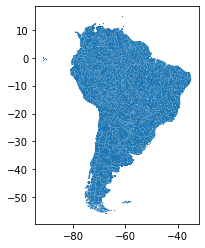

In [3]:
import geopandas as gpd
basins = gpd.read_file("../resources/hydrobasins_southam.shp")
basins.plot()

In [4]:
import pandas as pd

colours_i_like = ['#A1CAF1',  '#875692', '#008856',  '#0067A5', '#BE0032',
                  '#222222', '#848482', '#F3C300',  'blue', '#F38400',
                  '#E68FAC', '#604E97', '#F3C300', '#B3446C', '#C2B280', 
                  '#F6A600', '#882D17', '#E25822', '#8DB600',
                  '#F99379',  '#DCD300', '#F3C300', '#E68FAC', '#C2B280',
                  '#222222']

colors_df = pd.DataFrame({'basin': basins.MAJ_NAME.unique().tolist(), 'colors': colours_i_like})

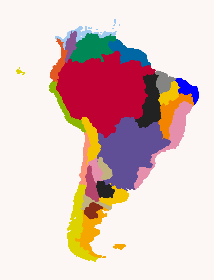

In [5]:
basins = pd.merge(basins, 
                  colors_df, 
                  left_on='MAJ_NAME', 
                  right_on='basin', 
                  how='left')

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
basins.plot(ax=ax, 
            edgecolor='face', 
            color=basins['colors'])
ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
from shapely.geometry import mapping
from rasterio import mask as msk 
import numpy as np

sa_array, clipped_transform = msk.mask(img, 
                                       [mapping(geom) for geom in basins.geometry.tolist()], 
                                       crop=True)
sa_array, clipped_transform = msk.mask(img, 
                                       [mapping(geom) for geom in basins.geometry.tolist()], 
                                       crop=True, 
                                       nodata=(np.amin(sa_array[0]) - 1))

value_range = np.amax(sa_array) + abs(np.amin(sa_array))

### Exercise

- Convert the basin Polygons to LineStrings corresponding to their boundaries.
- Create a new GeoDataFrame containing the MAJ_NAME and the basin boundary.
- Plot the basin boundaries

In [7]:
from shapely.ops import unary_union

geoms = [unary_union(basins.loc[basins['MAJ_NAME'] == poly_basin].geometry.tolist()) for poly_basin in basins.MAJ_NAME.unique().tolist()]
geoms = [geom.boundary for geom in geoms]

In [8]:
print(geoms)

[<shapely.geometry.multilinestring.MultiLineString object at 0x000001C02472CB50>, <shapely.geometry.multilinestring.MultiLineString object at 0x000001C02466FF10>, <shapely.geometry.multilinestring.MultiLineString object at 0x000001C02466FB80>, <shapely.geometry.multilinestring.MultiLineString object at 0x000001C02466FD90>, <shapely.geometry.multilinestring.MultiLineString object at 0x000001C02466F940>, <shapely.geometry.multilinestring.MultiLineString object at 0x000001C02466F8B0>, <shapely.geometry.multilinestring.MultiLineString object at 0x000001C026776130>, <shapely.geometry.linestring.LineString object at 0x000001C0267764C0>, <shapely.geometry.linestring.LineString object at 0x000001C026776880>, <shapely.geometry.linestring.LineString object at 0x000001C026776550>, <shapely.geometry.multilinestring.MultiLineString object at 0x000001C026776190>, <shapely.geometry.multilinestring.MultiLineString object at 0x000001C026776970>, <shapely.geometry.multilinestring.MultiLineString object 

In [9]:
new_basins = gpd.GeoDataFrame(pd.DataFrame({'Basin': basins.MAJ_NAME.unique().tolist()}), 
                              geometry=geoms)

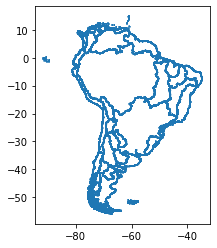

In [10]:
new_basins.plot()
plt.show()

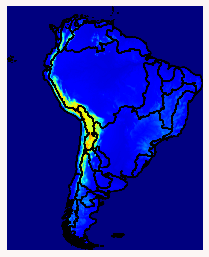

In [11]:
from rasterio.plot import show

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(3.5, 7)

show(sa_array, ax=ax, 
     transform=clipped_transform, 
     cmap='jet')
new_basins.plot(ax=ax, 
                edgecolor='black', 
                lw=1)

ax.axis('off')
plt.show()

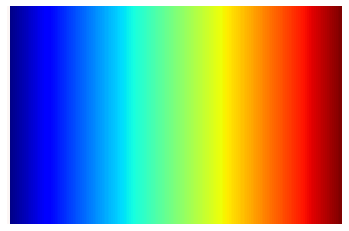

In [12]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib import cm

our_cmap = cm.get_cmap('jet', int((value_range - 5300) / 10))
newcolors = our_cmap(np.linspace(0, 1, int((value_range - 5300) / 10)))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors[:1, :] = background_colour
our_cmap = ListedColormap(newcolors)

bounds = np.arange(np.amin(sa_array), np.amax(sa_array)-5300, 10)
norm = BoundaryNorm(bounds, our_cmap.N)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect='auto', cmap=our_cmap)
plt.axis('off')
plt.show()

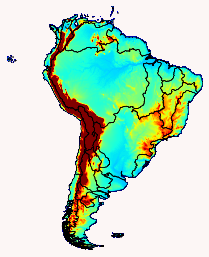

In [13]:
from rasterio.plot import show

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(3.5, 7)

show(sa_array, ax=ax, 
     transform=clipped_transform, 
     cmap=our_cmap, 
     norm=norm)
new_basins.plot(ax=ax, 
                edgecolor='black', 
                lw=0.5)
ax.axis('off')
plt.show()

### Exercise

Use another dataset to generate a map for a different continent or country!

https://data.apps.fao.org/map/catalog/srv/eng/catalog.search;jsessionid=AAC7809A66394973A2D96B618A2C7A1C?node=srv#/search?resultType=details&sortBy=relevance&fast=index&_content_type=json&from=1&to=50&any=Hydrological%20basin